# Evaluation pipeline

## 0 Imports and Constants

In [10]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [11]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [12]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [13]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'vae'

In [14]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_fc_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_fc_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h       snow_1h  \
count   342132.000000  342132.000000  342132.000000  3.421320e+05   
mean      3110.272211     272.052926       0.000039  3.956516e-07   
std       1732.462658       8.126521       0.006403  7.766697e-05   
min          0.000000     255.052612       0.000000  0.000000e+00   
25%       1539.943085     266.465378       0.000000  0.000000e+00   
50%       3539.827271     270.111023       0.000000  0.000000e+00   
75%       4650.749023     276.888931       0.000000  0.000000e+00   
max       7863.495605     323.557587       2.713800  3.641696e-02   

          clouds_all  
count  342132.000000  
mean       40.241452  
std        31.718849  
min         0.000000  
25%        10.922024  
50%        36.420538  
75%        67.570496  
max       209.785583  


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511.000000  

In [15]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,342132.000000,342132.000000,342132.000000,3.421320e+05,342132.000000
mean,3110.272211,272.052926,0.000039,3.956516e-07,40.241452
std,1732.462658,8.126521,0.006403,7.766697e-05,31.718849
min,0.000000,255.052612,0.000000,0.000000e+00,0.000000
25%,1539.943085,266.465378,0.000000,0.000000e+00,10.922024
50%,3539.827271,270.111023,0.000000,0.000000e+00,36.420538
75%,4650.749023,276.888931,0.000000,0.000000e+00,67.570496
max,7863.495605,323.557587,2.713800,3.641696e-02,209.785583


In [16]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [17]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [18]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.6220050059258938
Training Loss: 0.48627522721886635
Training Loss: 0.314744997471571
Validation Loss: 0.12465617529461893
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09977820385247468
Training Loss: 0.06715341925621032
Training Loss: 0.063205049559474
Validation Loss: 0.055307844046796305
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05896241033449769
Training Loss: 0.05510758692398667
Training Loss: 0.05384606738574803
Validation Loss: 0.04846801939472724
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05052352212369442
Training Loss: 0.04701870065182447
Training Loss: 0.04556771523319185
Validation Loss: 0.04118126651711678
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04222930275835097
Training Loss: 0.03877700567245483
Training Loss: 0.

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:20<30:00, 200.05s/it]

Epoch: 1
Training Loss: 0.1946107303351164
Training Loss: 0.14230097241699696
Training Loss: 0.10117834944278002
Validation Loss: 0.08098742495594399
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07494399717077613
Training Loss: 0.06846125405281782
Training Loss: 0.06612248545512557
Validation Loss: 0.06268798928247409
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06327839961275458
Training Loss: 0.06088252447545529
Training Loss: 0.059347399212419986
Validation Loss: 0.055814411240012456
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05624546503648162
Training Loss: 0.0536060643941164
Training Loss: 0.05185611994937062
Validation Loss: 0.048062970694363785
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04831133077852428
Training Loss: 0.04534772098995745
Training Los

 20%|██        | 2/10 [06:35<26:20, 197.59s/it]

Training Loss: 0.006258926085429266
Validation Loss: 0.0030543958569426884
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08033221714198589
Training Loss: 0.07159724548459052
Training Loss: 0.06900742026045918
Validation Loss: 0.0632752805864543
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06510398318991065
Training Loss: 0.06154180390760303
Training Loss: 0.058945679124444726
Validation Loss: 0.05378444015644909
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0539789822883904
Training Loss: 0.049679268952459096
Training Loss: 0.046213485151529315
Validation Loss: 0.04151800048820088
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.040884039914235476
Training Loss: 0.036601162515580654
Training Loss: 0.033491766611114145
Validation Loss: 0.029540328371725724
Validation A

 30%|███       | 3/10 [09:54<23:06, 198.02s/it]

Epoch: 1
Training Loss: 0.22054495327174664
Training Loss: 0.1730988596007228
Training Loss: 0.1250059237331152
Validation Loss: 0.08500637105676566
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08108500573784112
Training Loss: 0.06704802401363849
Training Loss: 0.06252711603417993
Validation Loss: 0.05896319281519129
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.060355073548853395
Training Loss: 0.057959102392196656
Training Loss: 0.05636551544070244
Validation Loss: 0.05277241634602627
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0532435773126781
Training Loss: 0.050017139324918386
Training Loss: 0.04757883628830314
Validation Loss: 0.043173110970620356
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.042956944406032566
Training Loss: 0.03886967815458774
Training Lo

 40%|████      | 4/10 [13:14<19:53, 198.86s/it]

Training Loss: 0.0055230485112406314
Validation Loss: 0.0023769193062077414
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4962454660236835
Training Loss: 0.4137871681153774
Training Loss: 0.3193352841585875
Validation Loss: 0.20993529276901415
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.16798571705818177
Training Loss: 0.09077332021668554
Training Loss: 0.07520972391590476
Validation Loss: 0.06619639765847934
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07155446402728557
Training Loss: 0.06896799450740218
Training Loss: 0.06796163408085704
Validation Loss: 0.060664603675014514
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06523611318320036
Training Loss: 0.06274192374199629
Training Loss: 0.06179114924743771
Validation Loss: 0.05511064048898354
Validation Accurac

 50%|█████     | 5/10 [16:32<16:32, 198.49s/it]

Training Loss: 0.006905921227880754
Validation Loss: 0.003595691539211136
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6609871576726437
Training Loss: 0.5195754820108414
Training Loss: 0.37188401684165
Validation Loss: 0.2222573243165284
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1763650182634592
Training Loss: 0.10039347155019641
Training Loss: 0.06993307221680879
Validation Loss: 0.0543705564871263
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0587028862722218
Training Loss: 0.05514239970594645
Training Loss: 0.05421521346084773
Validation Loss: 0.04815530651405956
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05188424765132368
Training Loss: 0.04918225574307144
Training Loss: 0.04791418119333685
Validation Loss: 0.0419249784075812
Validation Accuracy: 0.0
***

 60%|██████    | 6/10 [19:49<13:12, 198.09s/it]

Training Loss: 0.006181383564253338
Validation Loss: 0.002975977942860277
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.28446144476532936
Training Loss: 0.16974366419017314
Training Loss: 0.08961342990398408
Validation Loss: 0.06054867310135552
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06248408369719982
Training Loss: 0.05927841214463115
Training Loss: 0.05739141494035721
Validation Loss: 0.053311407063784226
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.054561559036374094
Training Loss: 0.05171666592359543
Training Loss: 0.04953023755922913
Validation Loss: 0.04524524089241965
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04618107592687011
Training Loss: 0.04307763122022152
Training Loss: 0.04090561323799193
Validation Loss: 0.036822478590386634
Validation Accu

 70%|███████   | 7/10 [23:07<09:54, 198.05s/it]

Training Loss: 0.006920792137389071
Validation Loss: 0.003715014286611355
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.06528816249221564
Training Loss: 0.056659935507923365
Training Loss: 0.05332789913751185
Validation Loss: 0.046035853099454654
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.047047820314764975
Training Loss: 0.04227068655192852
Training Loss: 0.039174421820789576
Validation Loss: 0.03380121943655978
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.034656151104718445
Training Loss: 0.031622660951688884
Training Loss: 0.030007855491712688
Validation Loss: 0.02629571220722426
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.027323912982828914
Training Loss: 0.025165541884489356
Training Loss: 0.024289854164235295
Validation Loss: 0.021306751683103236
Validat

 80%|████████  | 8/10 [26:25<06:35, 197.92s/it]

Training Loss: 0.006603357056737877
Validation Loss: 0.003280606623111146
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4613712778687477
Training Loss: 0.3481502303481102
Training Loss: 0.2424332670122385
Validation Loss: 0.15884882998600436
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.13594827692955733
Training Loss: 0.09290393393486739
Training Loss: 0.06975213604047895
Validation Loss: 0.05861231161469824
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05998961789533496
Training Loss: 0.05690282139927149
Training Loss: 0.05592278067022562
Validation Loss: 0.053064387417241426
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.054596136920154095
Training Loss: 0.05257008565589785
Training Loss: 0.051355494651943445
Validation Loss: 0.04821347981021645
Validation Accurac

 90%|█████████ | 9/10 [29:44<03:18, 198.15s/it]

Training Loss: 0.005590599811985158
Validation Loss: 0.002476134559197163
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.40994480133056643
Training Loss: 0.32165304958820345
Training Loss: 0.2347013145685196
Validation Loss: 0.14268458550900556
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12255135895684362
Training Loss: 0.08453819094225765
Training Loss: 0.07808773159980774
Validation Loss: 0.06946894011638138
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07509193597361445
Training Loss: 0.07232574420049787
Training Loss: 0.07119759015738963
Validation Loss: 0.06424608420622482
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0686317765340209
Training Loss: 0.06614689597859978
Training Loss: 0.06511613888666033
Validation Loss: 0.05939968294474516
Validation Accuracy:

100%|██████████| 10/10 [33:01<00:00, 198.08s/it]

Training Loss: 0.006128846899955533
Validation Loss: 0.002929454679166626
Validation Accuracy: 0.0
**************************************************


100%|██████████| 10/10 [33:01<00:00, 198.20s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.20462791129946709
Training Loss: 0.1442306936904788
Training Loss: 0.10629907760769129
Validation Loss: 0.08513552341819479
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07717308843508362
Training Loss: 0.06852960521355271
Training Loss: 0.06516332793980836
Validation Loss: 0.06535580898687411
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06402371160686016
Training Loss: 0.062387199923396114
Training Loss: 0.060415193997323514
Validation Loss: 0.060363370904259465
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.059072562977671626
Training Loss: 0.05703952129930258
Training Loss: 0.05466381015256047
Validation Loss: 0.053919546044525805
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.05255565827712417
Training Loss: 0.04988417537882924
Training 

 10%|█         | 1/10 [03:24<30:44, 204.99s/it]

Validation Loss: 0.004386964246887044
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.46110781863331796
Training Loss: 0.3465456035733223
Training Loss: 0.24009787883609535
Validation Loss: 0.15063659470067936
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11925822196528316
Training Loss: 0.08020650098100304
Training Loss: 0.06690314454957842
Validation Loss: 0.06502624942261852
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06373954180628061
Training Loss: 0.06173936262726784
Training Loss: 0.05980645896866918
Validation Loss: 0.059785106941387896
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05866953432559967
Training Loss: 0.05637970168143511
Training Loss: 0.05411787085235119
Validation Loss: 0.05344710162097818
Validation Accuracy: 0.0
*****************************

 20%|██        | 2/10 [06:50<27:23, 205.46s/it]

Validation Loss: 0.003346375143940278
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3175283642858267
Training Loss: 0.23920435510575772
Training Loss: 0.17821036484092473
Validation Loss: 0.12840633052453565
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10835045980289579
Training Loss: 0.07875162903219461
Training Loss: 0.06725286804139614
Validation Loss: 0.0656657697988695
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06457320315763354
Training Loss: 0.06207636374980211
Training Loss: 0.05933450585231185
Validation Loss: 0.05883261923458469
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.057713247407227754
Training Loss: 0.05502107606269419
Training Loss: 0.05203148620203137
Validation Loss: 0.05107541596830896
Validation Accuracy: 0.0
******************************

 30%|███       | 3/10 [10:18<24:04, 206.31s/it]

Validation Loss: 0.003421954273670033
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.12474532742053271
Training Loss: 0.09269493263214827
Training Loss: 0.07918713917955757
Validation Loss: 0.07632869197411483
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07404469598084688
Training Loss: 0.072354489043355
Training Loss: 0.0702122607640922
Validation Loss: 0.07060931957839581
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06864092653617263
Training Loss: 0.0668930558860302
Training Loss: 0.06438453884795309
Validation Loss: 0.06410416182172432
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06208335055038333
Training Loss: 0.059435053523629905
Training Loss: 0.056178844571113586
Validation Loss: 0.054701506965950636
Validation Accuracy: 0.0
******************************

 40%|████      | 4/10 [13:45<20:40, 206.69s/it]

Validation Loss: 0.004015008979764757
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11305775558575988
Training Loss: 0.08543280201032757
Training Loss: 0.07361653089523315
Validation Loss: 0.07131224487688434
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06898728840053081
Training Loss: 0.06720968572422863
Training Loss: 0.06485621113330126
Validation Loss: 0.06443274502506417
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0627059338800609
Training Loss: 0.06052455948665738
Training Loss: 0.05773122129961848
Validation Loss: 0.056397400911520706
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.054636159967631104
Training Loss: 0.05148691138252616
Training Loss: 0.04803316212259233
Validation Loss: 0.04559852958269668
Validation Accuracy: 0.0
****************************

 50%|█████     | 5/10 [17:12<17:14, 206.87s/it]

Validation Loss: 0.0028112819591626067
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.23046099729835987
Training Loss: 0.1674527344480157
Training Loss: 0.12379620401188732
Validation Loss: 0.08951215856195835
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07602413142099977
Training Loss: 0.06103754758834839
Training Loss: 0.05668487410992384
Validation Loss: 0.0563875243193313
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05460902158170938
Training Loss: 0.05205836560577154
Training Loss: 0.04931826437823474
Validation Loss: 0.04833826036558727
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04660181609913707
Training Loss: 0.04344240550883114
Training Loss: 0.04027615156024694
Validation Loss: 0.03849173313153259
Validation Accuracy: 0.0
******************************

 60%|██████    | 6/10 [20:39<13:47, 206.80s/it]

Validation Loss: 0.0033900263710104433
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4577089389413595
Training Loss: 0.31788351722061636
Training Loss: 0.2106758189946413
Validation Loss: 0.13611018460955512
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11627556812018155
Training Loss: 0.08691109033301472
Training Loss: 0.07481244506314397
Validation Loss: 0.07210935995485006
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07024133127182722
Training Loss: 0.06819674143567682
Training Loss: 0.06565261628478765
Validation Loss: 0.06598030509992261
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06432097725570202
Training Loss: 0.06240155046805739
Training Loss: 0.059605265650898215
Validation Loss: 0.05953953447594736
Validation Accuracy: 0.0
*****************************

 70%|███████   | 7/10 [24:06<10:21, 207.02s/it]

Validation Loss: 0.003396920732280051
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07287280580028892
Training Loss: 0.06778148774057627
Training Loss: 0.06463149726390839
Validation Loss: 0.06477800124649251
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06264273351058364
Training Loss: 0.06001817716285587
Training Loss: 0.056665459871292116
Validation Loss: 0.056141831849314525
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05396249402314424
Training Loss: 0.05059395195916295
Training Loss: 0.046754699824377896
Validation Loss: 0.04525053541939915
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.043216810151934626
Training Loss: 0.03924696593545377
Training Loss: 0.035491315759718416
Validation Loss: 0.03379077004959409
Validation Accuracy: 0.0
************************

 80%|████████  | 8/10 [27:35<06:55, 207.62s/it]

Validation Loss: 0.002486951336568075
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11550922002643346
Training Loss: 0.08582363769412041
Training Loss: 0.0713075990974903
Validation Loss: 0.06861564740957168
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06680411994457244
Training Loss: 0.06453017868101597
Training Loss: 0.0615724291279912
Validation Loss: 0.06095499181178179
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05910857930779457
Training Loss: 0.056305818110704425
Training Loss: 0.052840765342116354
Validation Loss: 0.05121632158923685
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04939159575849771
Training Loss: 0.04585547186434269
Training Loss: 0.04195582555606961
Validation Loss: 0.03943262778724847
Validation Accuracy: 0.0
*****************************

 90%|█████████ | 9/10 [31:02<03:27, 207.43s/it]

Validation Loss: 0.0023610710213484054
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.498257510215044
Training Loss: 0.3963012209534645
Training Loss: 0.28209758311510086
Validation Loss: 0.16066164979606531
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11802191540598869
Training Loss: 0.07266905395314098
Training Loss: 0.0607284951582551
Validation Loss: 0.059206827323925626
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058152924049645664
Training Loss: 0.055708602368831635
Training Loss: 0.054012931883335114
Validation Loss: 0.05352831009273114
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.052663454730063675
Training Loss: 0.049810728281736376
Training Loss: 0.04752208637073636
Validation Loss: 0.04621498075345259
Validation Accuracy: 0.0
**************************

100%|██████████| 10/10 [34:29<00:00, 206.95s/it]


Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.34149534240365026
Training Loss: 0.24465509936213492
Training Loss: 0.15104206934571265
Validation Loss: 0.07920136017589596
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06285532379522919
Training Loss: 0.04695094401016831
Training Loss: 0.04272765870206058
Validation Loss: 0.040997693929092846
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04033104571513832
Training Loss: 0.038537736386060714
Training Loss: 0.037189010959118605
Validation Loss: 0.03542901201995725
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.034714588150382045
Training Loss: 0.03262360775843263
Training Loss: 0.030978870317339896
Validation Loss: 0.028800348152911198
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.027995071383193137
Training Loss: 0.02554490958340466
Traini

 10%|█         | 1/10 [03:28<31:17, 208.64s/it]

Validation Loss: 0.0002725531202633657
Validation Accuracy: 4.147545889864326
**************************************************
Epoch: 1
Training Loss: 0.6346704217791558
Training Loss: 0.48101319417357447
Training Loss: 0.30218874253332617
Validation Loss: 0.13114551733658966
Validation Accuracy: 7.691540303272147
**************************************************
Epoch: 2
Training Loss: 0.08808215491473675
Training Loss: 0.045062266010791066
Training Loss: 0.0331131602358073
Validation Loss: 0.03005736817569373
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.02976980833336711
Training Loss: 0.028421776900067926
Training Loss: 0.027648136215284468
Validation Loss: 0.026698852655108414
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.026440486437641086
Training Loss: 0.024982493137940764
Training Loss: 0.024141954695805906
Validation Loss: 0.023083648977374565
Validation Accuracy

 20%|██        | 2/10 [06:55<27:42, 207.75s/it]

Validation Loss: 0.0005437051712349317
Validation Accuracy: 4.0527733439744615
**************************************************
Epoch: 1
Training Loss: 0.30449420034885405
Training Loss: 0.22467376582324505
Training Loss: 0.14711292833089828
Validation Loss: 0.08656578898096884
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07071886686608195
Training Loss: 0.052486549634486436
Training Loss: 0.04517047056928277
Validation Loss: 0.04278535737172185
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04196019446477294
Training Loss: 0.040301782367751005
Training Loss: 0.03878489857539535
Validation Loss: 0.03725881057702962
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.036325553758069874
Training Loss: 0.03427725919522345
Training Loss: 0.03247726066969335
Validation Loss: 0.030573732099969293
Validation Accuracy: 0.0
*********

 30%|███       | 3/10 [10:23<24:12, 207.57s/it]

Validation Loss: 0.00019592848747374241
Validation Accuracy: 4.898244213886672
**************************************************
Epoch: 1
Training Loss: 0.2807636169344187
Training Loss: 0.213327721580863
Training Loss: 0.1432046001404524
Validation Loss: 0.07591373442188322
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.059268111940473316
Training Loss: 0.04463104899972677
Training Loss: 0.040822320356965064
Validation Loss: 0.03802085813530331
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.036812181631103155
Training Loss: 0.034030337929725644
Training Loss: 0.03207931352779269
Validation Loss: 0.029932824260029713
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.02906429166905582
Training Loss: 0.026678190850652754
Training Loss: 0.0250218634493649
Validation Loss: 0.023040782665448813
Validation Accuracy: 0.0
***********

 40%|████      | 4/10 [13:50<20:44, 207.44s/it]

Validation Loss: 0.0002891398282534984
Validation Accuracy: 4.611432561851556
**************************************************
Epoch: 1
Training Loss: 0.0736953029409051
Training Loss: 0.05786919470876455
Training Loss: 0.04705157160758972
Validation Loss: 0.04025876885227984
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.038371943663805724
Training Loss: 0.034782487349584695
Training Loss: 0.03141014482825995
Validation Loss: 0.02746861458199317
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.025759594617411494
Training Loss: 0.021527487337589263
Training Loss: 0.01787948046810925
Validation Loss: 0.013704795494425897
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.012187374036293476
Training Loss: 0.008651217108126729
Training Loss: 0.00637893256964162
Validation Loss: 0.004823435086226247
Validation Accuracy: 1.197126895

 50%|█████     | 5/10 [17:18<17:17, 207.55s/it]

Validation Loss: 0.0003361250632803486
Validation Accuracy: 6.531823623304071
**************************************************
Epoch: 1
Training Loss: 0.04778273208998143
Training Loss: 0.042160122552886606
Training Loss: 0.03956277746707201
Validation Loss: 0.03670877012210851
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03530800560489297
Training Loss: 0.031910161916166545
Training Loss: 0.028705035336315632
Validation Loss: 0.024929349648885886
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.023262873021885754
Training Loss: 0.019429670786485075
Training Loss: 0.01625491469632834
Validation Loss: 0.01311048647836267
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.01206918662181124
Training Loss: 0.009669534082058817
Training Loss: 0.008100997335277497
Validation Loss: 0.006706571778771597
Validation Accuracy: 0.0
*****

 60%|██████    | 6/10 [20:45<13:49, 207.49s/it]

**************************************************
Epoch: 1
Training Loss: 0.21781087420880796
Training Loss: 0.15586715877056123
Training Loss: 0.08700761871412396
Validation Loss: 0.04148135100121938
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.036756536047905686
Training Loss: 0.03339294116944075
Training Loss: 0.031986784394830464
Validation Loss: 0.03025825577657982
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.029427005751058458
Training Loss: 0.027252989979460837
Training Loss: 0.025458881752565502
Validation Loss: 0.023153251963121266
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.022175192548893392
Training Loss: 0.019633875084109603
Training Loss: 0.017549393251538276
Validation Loss: 0.015049261769394301
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.01410

 70%|███████   | 7/10 [24:12<10:22, 207.47s/it]

Epoch: 1
Training Loss: 0.3074703060090542
Training Loss: 0.2376820120215416
Training Loss: 0.16796035349369048
Validation Loss: 0.10641374106014241
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08725129175931215
Training Loss: 0.059765910264104605
Training Loss: 0.04409310454502702
Validation Loss: 0.03705125336415608
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03591009269468486
Training Loss: 0.03398836188949644
Training Loss: 0.032669932637363674
Validation Loss: 0.03148534097942893
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.030834768805652855
Training Loss: 0.028965921914204953
Training Loss: 0.02741791270673275
Validation Loss: 0.025803772826268022
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.024981295736506582
Training Loss: 0.022740484839305283
Training

 80%|████████  | 8/10 [27:40<06:54, 207.43s/it]

Validation Loss: 0.0003588171614016609
Validation Accuracy: 5.763667198723065
**************************************************
Epoch: 1
Training Loss: 0.13816271774470806
Training Loss: 0.09593763578683139
Training Loss: 0.06375833591446281
Validation Loss: 0.04638863419437542
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.043702035201713445
Training Loss: 0.04075681429356336
Training Loss: 0.03907952794805169
Validation Loss: 0.037345567905453333
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.036463464349508284
Training Loss: 0.034138247165828944
Training Loss: 0.032021097084507344
Validation Loss: 0.029480516868929624
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.028365976568311455
Training Loss: 0.025496956226415932
Training Loss: 0.022982577071525158
Validation Loss: 0.019956983964078585
Validation Accuracy: 0.0
****

 90%|█████████ | 9/10 [31:07<03:27, 207.51s/it]

Validation Loss: 0.00022719725672163424
Validation Accuracy: 5.763667198723065
**************************************************
Epoch: 1
Training Loss: 0.052224200423806905
Training Loss: 0.04910163760185242
Training Loss: 0.0465200131200254
Validation Loss: 0.043782245815216496
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04245041877962649
Training Loss: 0.03924986807629466
Training Loss: 0.036322922389954326
Validation Loss: 0.03285196534873054
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.031267337165772915
Training Loss: 0.0273478939011693
Training Loss: 0.023917345469817518
Validation Loss: 0.02004775232713482
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.018613586393184958
Training Loss: 0.01515271954005584
Training Loss: 0.012664573874790221
Validation Loss: 0.010290477978970917
Validation Accuracy: 0.0
*******

100%|██████████| 10/10 [34:35<00:00, 207.60s/it]


Validation Loss: 0.00024317450485323612
Validation Accuracy: 4.9680766161213095
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.07559936325997114
Training Loss: 0.06012137442827225
Training Loss: 0.05579671649262309
Training Loss: 0.0460018296353519
Training Loss: 0.03469001243822276
Training Loss: 0.032972825029864906
Training Loss: 0.03127580384258181
Validation Loss: 0.03555424339818151
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04625193455256522
Training Loss: 0.0428354992158711
Training Loss: 0.041107685463503005
Training Loss: 0.03200733607634902
Training Loss: 0.021502938265912236
Training Loss: 0.019689755556173624
Training Loss: 0.018214305457659067
Validation Loss: 0.02201256752432732
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0312507389113307
Training Loss: 0.028367122816853226
Training Loss: 0.027816271898336707
Training Loss: 0.020093446797691285
Training Loss: 0.011893343981355428
Training Loss: 0.010930348120164126
Training Loss: 0.010238326441030949
Vali

 10%|█         | 1/10 [06:46<1:00:56, 406.26s/it]

Training Loss: 0.00034879544473369605
Validation Loss: 0.0011383046107545445
Validation Accuracy: 4.424157303370786
**************************************************
Epoch: 1
Training Loss: 0.31159363128244877
Training Loss: 0.24922427825629712
Training Loss: 0.1859797565639019
Training Loss: 0.10470501322299242
Training Loss: 0.05380007728934288
Training Loss: 0.04035876463167369
Training Loss: 0.03589706971310079
Validation Loss: 0.039556528417191254
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05038401777856052
Training Loss: 0.047733361357823016
Training Loss: 0.04666155793704092
Training Loss: 0.03924189934507012
Training Loss: 0.029511801935732364
Training Loss: 0.027977696964517237
Training Loss: 0.02645707511808723
Validation Loss: 0.02942924267413576
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.038232598630711434
Training Loss: 0.034867217959836126
Training Loss: 

 20%|██        | 2/10 [12:54<51:12, 384.02s/it]  

Training Loss: 0.0005430887062539114
Validation Loss: 0.0012579775186018383
Validation Accuracy: 3.8623595505617976
INFO: Validation loss did not improve in epoch 181
Early stopping after 181 epochs
Epoch: 1
Training Loss: 0.07410498913377524
Training Loss: 0.06559625221416354
Training Loss: 0.06286236567422748
Training Loss: 0.05398967389017344
Training Loss: 0.042890129536390306
Training Loss: 0.04102567095309496
Training Loss: 0.03915710381232202
Validation Loss: 0.043895695881729715
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05352214464917779
Training Loss: 0.04926854440942407
Training Loss: 0.04650874920189381
Training Loss: 0.037694604694843294
Training Loss: 0.027204290637746452
Training Loss: 0.024585873642936348
Training Loss: 0.021959566227160394
Validation Loss: 0.024645208552033268
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03154314801096916
Training Loss: 0

 30%|███       | 3/10 [19:42<46:03, 394.72s/it]

Training Loss: 0.0005655209260294214
Validation Loss: 0.001336730330352312
Validation Accuracy: 2.8323970037453186
**************************************************
Epoch: 1
Training Loss: 0.522173540443182
Training Loss: 0.40745860859751704
Training Loss: 0.29184811376035213
Training Loss: 0.1629080406948924
Training Loss: 0.07825761336833238
Training Loss: 0.04372871830128133
Training Loss: 0.03196134736761451
Validation Loss: 0.03337076455633738
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04345083516091108
Training Loss: 0.04180072404444218
Training Loss: 0.04161941266618669
Training Loss: 0.03428824798204005
Training Loss: 0.025506872832775116
Training Loss: 0.024472997677512466
Training Loss: 0.0238098347466439
Validation Loss: 0.027540613579727737
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.036169850816950205
Training Loss: 0.03421148043125868
Training Loss: 0.0338

 40%|████      | 4/10 [26:28<39:56, 399.46s/it]

Training Loss: 0.0004233192862011492
Validation Loss: 0.0011524366241468167
Validation Accuracy: 3.0898876404494384
**************************************************
Epoch: 1
Training Loss: 0.39342418521642686
Training Loss: 0.28349082805216314
Training Loss: 0.19543769009411335
Training Loss: 0.11273486671969295
Training Loss: 0.06345686631277203
Training Loss: 0.04906953515484929
Training Loss: 0.042026065709069374
Validation Loss: 0.045372307600544184
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05730929841287434
Training Loss: 0.053282654974609614
Training Loss: 0.05188218282535672
Training Loss: 0.044147851606830955
Training Loss: 0.0341847874969244
Training Loss: 0.03298375035636127
Training Loss: 0.03189028694294393
Validation Loss: 0.0354294137338574
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0454220212623477
Training Loss: 0.0425896074436605
Training Loss: 0.040

 50%|█████     | 5/10 [33:15<33:30, 402.12s/it]

Training Loss: 0.0006388690057065105
Validation Loss: 0.001297468085069565
Validation Accuracy: 3.6399812734082397
**************************************************
Epoch: 1
Training Loss: 0.36031865045428274
Training Loss: 0.25468681402504445
Training Loss: 0.17757144793868065
Training Loss: 0.10452530656009912
Training Loss: 0.060113382562994956
Training Loss: 0.04782090491615236
Training Loss: 0.042544241566210984
Validation Loss: 0.046902416092570356
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.059343252666294574
Training Loss: 0.056348092295229434
Training Loss: 0.05532000161707401
Training Loss: 0.04642601194791496
Training Loss: 0.03549248295836151
Training Loss: 0.03404280114918947
Training Loss: 0.03264846094883978
Validation Loss: 0.03667994696046976
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04758160776458681
Training Loss: 0.04462278353981674
Training Loss: 0

 60%|██████    | 6/10 [40:02<26:54, 403.71s/it]

Training Loss: 0.000508832315535983
Validation Loss: 0.001245563486499419
Validation Accuracy: 3.3122659176029963
**************************************************
Epoch: 1
Training Loss: 0.06707481550052762
Training Loss: 0.061813785713166
Training Loss: 0.05862034447491169
Training Loss: 0.047708195466548205
Training Loss: 0.03529272593557835
Training Loss: 0.031169495256617667
Training Loss: 0.026339354766532777
Validation Loss: 0.029322288630439546
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03770504226908088
Training Loss: 0.03170990993734449
Training Loss: 0.02835677801631391
Training Loss: 0.0171973408292979
Training Loss: 0.0068370706646237525
Training Loss: 0.005777155413525179
Training Loss: 0.0051927085407078265
Validation Loss: 0.011141043171209845
Validation Accuracy: 0.9597378277153558
**************************************************
Epoch: 3
Training Loss: 0.020978288487531246
Training Loss: 0.01879154063528403

 70%|███████   | 7/10 [46:48<20:13, 404.58s/it]

Training Loss: 0.0004480650743789738
Validation Loss: 0.0011507421208188907
Validation Accuracy: 2.6451310861423223
**************************************************
Epoch: 1
Training Loss: 0.08414983300492168
Training Loss: 0.05992958874441683
Training Loss: 0.050934832375496626
Training Loss: 0.040762087535113095
Training Loss: 0.031017804984003305
Training Loss: 0.029497649394907056
Training Loss: 0.027879628664813937
Validation Loss: 0.03149424741316712
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04043751656077802
Training Loss: 0.037152918791398405
Training Loss: 0.03547044469043612
Training Loss: 0.027103586392477154
Training Loss: 0.0179622092936188
Training Loss: 0.016163384343963118
Training Loss: 0.014579568125773221
Validation Loss: 0.01748655036035995
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.025321319899521768
Training Loss: 0.02248149338643998
Training Lo

 80%|████████  | 8/10 [53:35<13:30, 405.28s/it]

Training Loss: 0.0005180083501181798
Validation Loss: 0.0011963465063870198
Validation Accuracy: 2.949438202247191
**************************************************
Epoch: 1
Training Loss: 0.07099777279421687
Training Loss: 0.06120110756717622
Training Loss: 0.05764232290908694
Training Loss: 0.048133208937942984
Training Loss: 0.03672222166322172
Training Loss: 0.03440556342713535
Training Loss: 0.03221770619042218
Validation Loss: 0.03511100685161151
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0442211050260812
Training Loss: 0.04009477405808866
Training Loss: 0.037405811017379165
Training Loss: 0.02903895006980747
Training Loss: 0.01948086161632091
Training Loss: 0.01710594735108316
Training Loss: 0.01498058128170669
Validation Loss: 0.017177753303939485
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.024250381267629562
Training Loss: 0.021231737420894205
Training Loss: 0.

 90%|█████████ | 9/10 [1:00:21<06:45, 405.59s/it]

Training Loss: 0.0006630700829555281
Validation Loss: 0.001457800785553108
Validation Accuracy: 3.3239700374531833
**************************************************
Epoch: 1
Training Loss: 0.38558802753686905
Training Loss: 0.2952658627927303
Training Loss: 0.21043424855917692
Training Loss: 0.12128807866945862
Training Loss: 0.06612384164705873
Training Loss: 0.04755319008603692
Training Loss: 0.03986026396043599
Validation Loss: 0.04234184059645799
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05306552822701633
Training Loss: 0.05050562549382448
Training Loss: 0.04943779512308538
Training Loss: 0.041596584906801584
Training Loss: 0.03233565140515566
Training Loss: 0.031017241729423405
Training Loss: 0.02965291540604085
Validation Loss: 0.03275650014145098
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04198962140828371
Training Loss: 0.03942670958116651
Training Loss: 0.038

100%|██████████| 10/10 [1:07:08<00:00, 402.84s/it]

Training Loss: 0.0007785103088826873
Validation Loss: 0.0015662895487874313
Validation Accuracy: 2.118445692883895
**************************************************


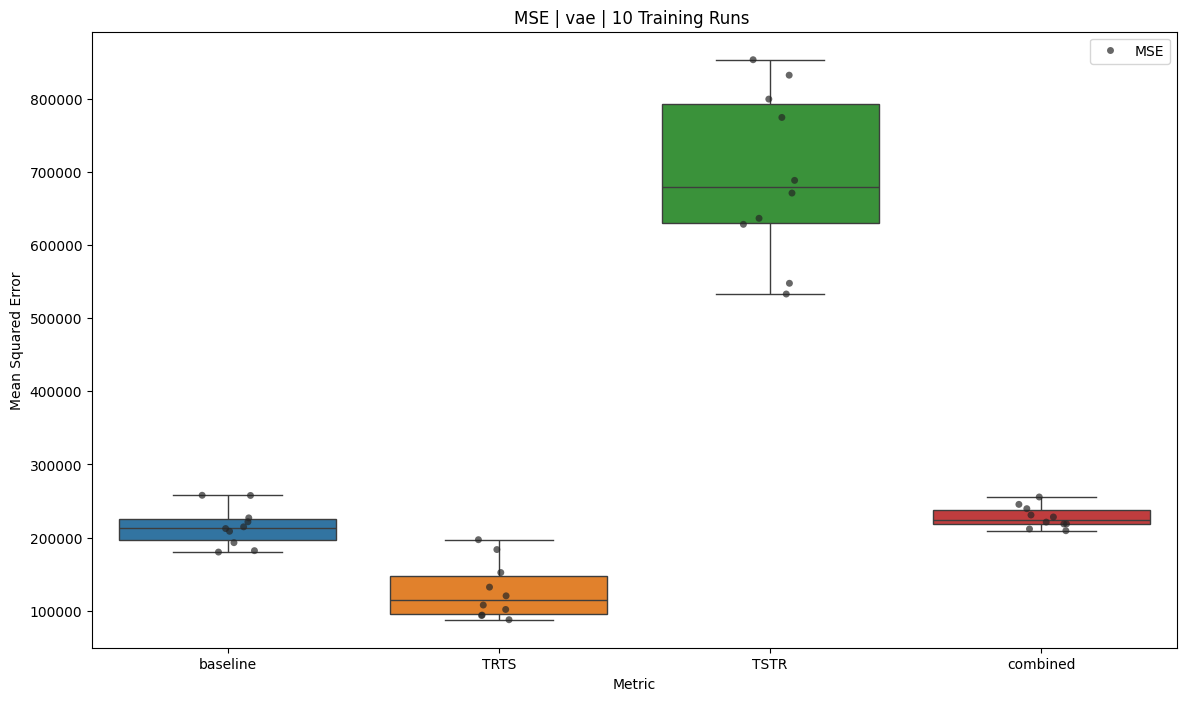

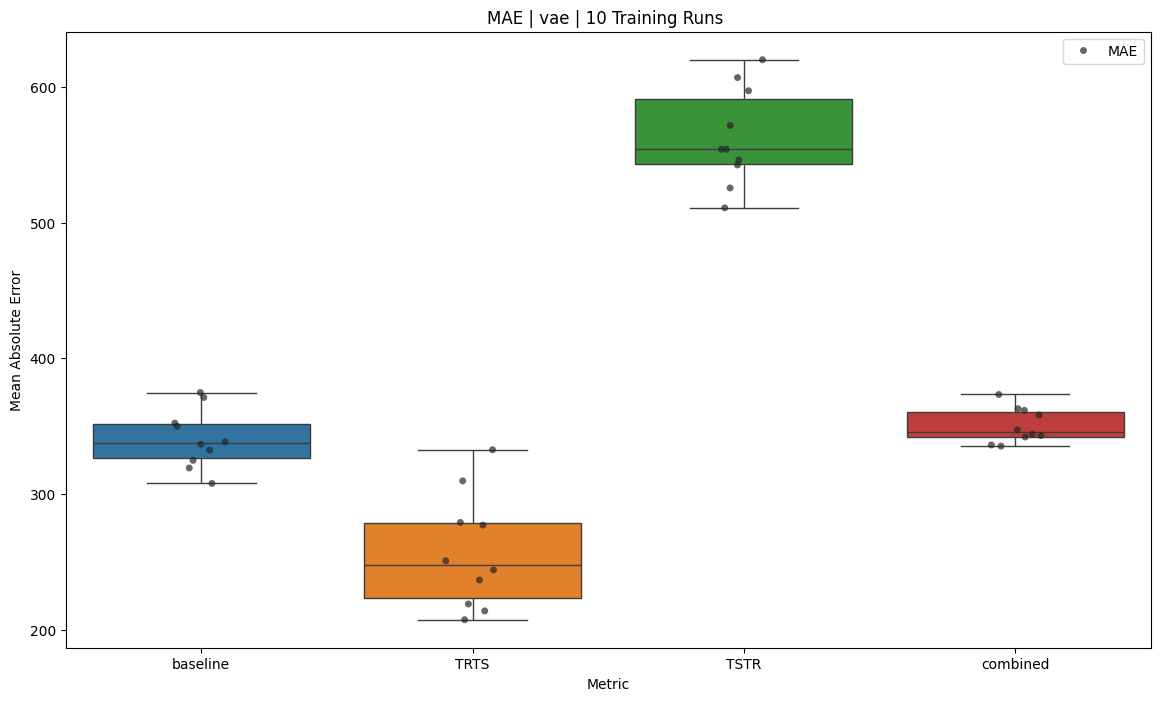

In [19]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [20]:
0.2*1e06

200000.0